# Tabular benchmark

Here is the code for comparing tree-based models and deep learning models on tabular data. The comparison is made on the benchmarks described in the article:
[Why do tree-based models still outperform deep learning on typical tabular data?](https://hal.science/hal-03723551/document)

To reproduce this code, download the repository https://github.com/LeoGrin/tabular-benchmark and put this notebook in the `src` directory.

## Data

To download data, run script `data/download_data.py` in the repo.

In [ ]:
import numpy
import pickle

def load_data(keyword=None, path_to_dir="../data", regression=False, categorical=False):
    if not categorical:
        if regression:
            with open("{}/numerical_only/regression/data_{}".format(path_to_dir, keyword), "rb") as f:
                X, y = pickle.load(f)
        else:
            with open("{}/numerical_only/balanced/data_{}".format(path_to_dir, keyword), "rb") as f:
                X, y = pickle.load(f)
            y = np.array(y).astype(np.int64)
        categorical_indicator = None
    else:
        if regression:
            with open("{}/num_and_cat/regression/data_{}".format(path_to_dir, keyword), "rb") as f:
                X, y, categorical_indicator = pickle.load(f)
        else:
            with open("{}/num_and_cat/balanced/data_{}".format(path_to_dir, keyword), "rb") as f:
                X, y, categorical_indicator = pickle.load(f)
            y = np.array(y).astype(np.int64)
        categorical_indicator = np.array(categorical_indicator).astype(bool)

    return np.array(X), np.array(y), categorical_indicator

In [ ]:
import os
from tabulate import tabulate

for task in ["regression", "balanced"]:
    for feature_type in ["numerical_only", "num_and_cat"]:
        datasets = os.listdir(f"../data/{feature_type}/{task}")
        datasets.remove(".gitignore")
        regression = (task == "regression")
        categorical = (feature_type == "num_and_cat")
        data_shapes = [["Name", "Shape"]]
        for dataset in datasets:
            keyword = dataset[len("data_"):]
            X, y, categorical_indicator = load_data(keyword, regression=regression, categorical=categorical)
            data_shapes.append((keyword, X.shape))
        print(f"regression={regression}, categorical={categorical}")
        print(tabulate(data_shapes, headers='firstrow', tablefmt='fancy_grid'))
        print()

regression=True, categorical=False
╒═════════════════════════╤══════════════╕
│ Name                    │ Shape        │
╞═════════════════════════╪══════════════╡
│ house_16H               │ (22784, 16)  │
├─────────────────────────┼──────────────┤
│ house_sales             │ (21613, 15)  │
├─────────────────────────┼──────────────┤
│ medical_charges         │ (163065, 3)  │
├─────────────────────────┼──────────────┤
│ houses                  │ (20640, 8)   │
├─────────────────────────┼──────────────┤
│ Bike_Sharing_Demand     │ (17379, 6)   │
├─────────────────────────┼──────────────┤
│ pol                     │ (15000, 26)  │
├─────────────────────────┼──────────────┤
│ superconduct            │ (21263, 79)  │
├─────────────────────────┼──────────────┤
│ nyc-taxi-green-dec-2016 │ (581835, 9)  │
├─────────────────────────┼──────────────┤
│ isolet                  │ (7797, 613)  │
├─────────────────────────┼──────────────┤
│ diamonds                │ (53940, 6)   │
├──────────────────

In [ ]:
from dataclasses import dataclass

@dataclass
class Benchmark:
    keyword: str
    regression: bool
    categorical: bool


benchmarks = [
    Benchmark("houses", True, False),
    Benchmark("elevators", True, False),
    Benchmark("fifa", True, False),
    Benchmark("analcatdata_supreme", True, True),
    Benchmark("house_sales", True, True),
    Benchmark("visualizing_soil", True, True),
    Benchmark("wine", False, False),
    Benchmark("phoneme", False, False),
    Benchmark("credit", False, False),
    Benchmark("compass", False, True),
    Benchmark("rl", False, True),
    Benchmark("electricity", False, True),
]


## Train & evaluate

In [ ]:
from model_configs import config_dic
import numpy as np
import pandas as pd
from scipy.stats import special_ortho_group
from sklearn.model_selection import train_test_split
from time import time
from train import train_model


def apply_random_rotation(x_train, x_test, y_train, y_test):
    num_samples, num_features = x_train.shape
    rotation_matrix = special_ortho_group.rvs(num_features, random_state=12)
    return (x_train @ rotation_matrix).astype(np.float32), (x_test @ rotation_matrix).astype(np.float32), y_train, y_test


def evaluate_model(fitted_model, x_train, y_train, x_test, y_test, metrics):
    y_hat_train = np.nan_to_num(fitted_model.predict(x_train))
    y_hat_test = np.nan_to_num(fitted_model.predict(x_test))
    
    train_results = []
    test_results = []
    
    for metric in metrics:
        train_results.append(metric(y_train, y_hat_train))
        test_results.append(metric(y_test, y_hat_test))

    return train_results, test_results


def conduct_experiments(benchmarks, models, random_rotation=False):
    train_regression_scores = {metric_name: pd.DataFrame(columns=[benchmark.keyword for benchmark in benchmarks if benchmark.regression], index=models) for metric_name in regression_metrics.keys()}
    test_regression_scores = {metric_name: pd.DataFrame(columns=[benchmark.keyword for benchmark in benchmarks if benchmark.regression], index=models) for metric_name in regression_metrics.keys()}
    train_classif_scores = {metric_name: pd.DataFrame(columns=[benchmark.keyword for benchmark in benchmarks if not benchmark.regression], index=models) for metric_name in classif_metrics.keys()}
    test_classif_scores = {metric_name: pd.DataFrame(columns=[benchmark.keyword for benchmark in benchmarks if not benchmark.regression], index=models) for metric_name in classif_metrics.keys()}
    time_df = pd.DataFrame(columns=[benchmark.keyword for benchmark in benchmarks], index=models)

    for benchmark in benchmarks:
        print(f"Comparing on benchmark {benchmark.keyword}")
        x, y, categorical_indicator = load_data(keyword=benchmark.keyword, regression=benchmark.regression, categorical=benchmark.categorical)
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=12, shuffle=True)
        if random_rotation:
            x_train, x_test, y_train, y_test = apply_random_rotation(x_train, x_test, y_train, y_test)
        for model_name in models:
            print(f"\t training {model_name}")
            start_time = time()

            model_config = config_dic[model_name]["regression" if benchmark.regression else "classif"]["default"]
            config = dict()
            for key in model_config.keys():
                new_value = list(model_config[key].values())[0]
                if type(new_value) == list:
                    new_value = new_value[0]
                config[key] = new_value
            if config["model_name"] == "ft_transformer" or config["model_name"] == "ft_transformer_regressor":
                config["model__module__d_token"] = (config["d_token"] // config["model__module__n_heads"]) * config["model__module__n_heads"]
            if config["model_type"] == "skorch":
                    config["model__max_epochs"] = 50
                    config["model__es_patience"] = 5
                    config["model__device"] = "cpu"
            config["regression"] = benchmark.regression
            config["data__regression"] = benchmark.regression
            config["data__categorical"] = benchmark.categorical and (not random_rotation)
            config["data__keyword"] = benchmark.keyword

            model, model_id = train_model(0, x_train, y_train, categorical_indicator if not random_rotation else None, config)

            if benchmark.regression:
                train_results, test_results = evaluate_model(model, x_train, y_train, x_test, y_test, regression_metrics.values())
                for i, metric_name in enumerate(regression_metrics):
                    train_regression_scores[metric_name].at[model_name, benchmark.keyword] = train_results[i]
                    test_regression_scores[metric_name].at[model_name, benchmark.keyword] = test_results[i]
                    print(f"\t\t{metric_name}: train {train_results[i]}, test {test_results[i]}")
            else:
                train_results, test_results = evaluate_model(model, x_train, y_train, x_test, y_test, classif_metrics.values())
                for i, metric_name in enumerate(classif_metrics):
                    train_classif_scores[metric_name].at[model_name, benchmark.keyword] = train_results[i]
                    test_classif_scores[metric_name].at[model_name, benchmark.keyword] = test_results[i]
                    print(f"\t\t{metric_name}: train {train_results[i]}, test {test_results[i]}")

            trained_time = time() - start_time
            time_df.at[model_name, benchmark.keyword] = trained_time
            print(f"\t\ttime: {trained_time} sec")
    return train_regression_scores, test_regression_scores, train_classif_scores, test_classif_scores, time_df

## Visualization

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")

log_scale_metrics = {"mean_squared_error", "mean_absolute_error", "regression_time", "classification_time"}
model_naming = {"gbt": "GradientBoosting", "rf": "RandomForest", "xgb": "XGBoost", "hgbt": "HistGradientBoosting", "ft_transformer": "FT-Transformer", "resnet": "ResNet", "mlp": "MLP"}
def visualize_bar(scores, title):
    fig, axs = plt.subplots(len(scores), 1)
    fig.set_size_inches(16, 12)
    fig.suptitle(title, fontsize=16)
    for i, metric in enumerate(scores):
        df = scores[metric]
        sns.barplot(ax=axs[i], x=np.repeat(df.columns, df.shape[0]), y=df.values.T.flatten(), hue=np.tile(df.index.map(model_naming), df.shape[1]))
        axs[i].set_title(metric, fontsize=12)
        if metric in log_scale_metrics:
            axs[i].set_yscale("log")

## Experiments

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, mean_squared_error, mean_absolute_error, r2_score

classif_metrics = {"accuracy": accuracy_score, "f1_score": f1_score, "roc_auc": roc_auc_score}
regression_metrics = {"mean_squared_error": mean_squared_error, "mean_absolute_error": mean_absolute_error, "r2_score": r2_score}

models = ["gbt", "rf", "xgb", "hgbt", "ft_transformer", "resnet", "mlp"]
train_regression_scores, test_regression_scores, train_classif_scores, test_classif_scores, time_df = conduct_experiments(benchmarks, models)

Comparing on benchmark houses
	 training gbt
		mean_squared_error: train 0.06407898814912963, test 0.06893398522943944
		mean_absolute_error: train 0.18749625797387576, test 0.19408842653220082
		r2_score: train 0.8018215762524721, test 0.7880056617222334
		time: 1.8031423091888428 sec
	 training rf
		mean_squared_error: train 0.007685294254251354, test 0.05457601761836874
		mean_absolute_error: train 0.05992178295379462, test 0.16070004468617208
		r2_score: train 0.9762315300953429, test 0.8321610639174141
		time: 5.233331918716431 sec
	 training xgb
		mean_squared_error: train 0.019274067133665085, test 0.05238891765475273
		mean_absolute_error: train 0.10257266461849213, test 0.16015994548797607
		r2_score: train 0.940390690199678, test 0.8388871031852414
		time: 0.5334560871124268 sec
	 training hgbt
		mean_squared_error: train 0.03983599307997419, test 0.05191033371661163
		mean_absolute_error: train 0.1431531103195453, test 0.1614988083915595
		r2_score: train 0.8767983929672282,

/Users/sizov/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


		accuracy: train 0.9988808058198098, test 0.78748370273794
		f1_score: train 0.9988674971687429, test 0.7995079950799509
		roc_auc: train 0.9988950276243094, test 0.7863924050632911
		time: 0.5715739727020264 sec
	 training ft_transformer
		accuracy: train 0.7280358142137661, test 0.7235984354628422
		f1_score: train 0.7364425162689805, test 0.7470167064439142
		roc_auc: train 0.7285670437604139, test 0.7214713488498707
		time: 31.359169006347656 sec
	 training resnet
		accuracy: train 0.7174034695019585, test 0.7014341590612777
		f1_score: train 0.754735308402137, test 0.749726775956284
		roc_auc: train 0.7194817153380689, test 0.6962739893834218
		time: 5.053637742996216 sec
	 training mlp
		accuracy: train 0.493564633463906, test 0.5149934810951761
		f1_score: train 0.6609216935181716, test 0.6798623063683304
		roc_auc: train 0.5, test 0.5
		time: 0.7924978733062744 sec
Comparing on benchmark phoneme
	 training gbt
		accuracy: train 0.9004504504504505, test 0.8466386554621849
		f1_

/Users/sizov/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


		accuracy: train 0.9932432432432432, test 0.8707983193277311
		f1_score: train 0.9931849159472966, test 0.87857847976308
		roc_auc: train 0.993255972707327, test 0.869782075909121
		time: 0.5715320110321045 sec
	 training ft_transformer
		accuracy: train 0.8608108108108108, test 0.8455882352941176
		f1_score: train 0.8667529107373868, test 0.8574199806013579
		roc_auc: train 0.8613373279901687, test 0.8441213486123071
		time: 17.662988901138306 sec
	 training resnet
		accuracy: train 0.8734234234234234, test 0.842436974789916
		f1_score: train 0.8767003071522598, test 0.8546511627906976
		roc_auc: train 0.8737726048901807, test 0.8409441169327241
		time: 5.998763084411621 sec
	 training mlp
		accuracy: train 0.5049549549549549, test 0.4884453781512605
		f1_score: train 0.0, test 0.0
		roc_auc: train 0.5, test 0.5
		time: 0.9528682231903076 sec
Comparing on benchmark credit
	 training gbt
		accuracy: train 0.7899820497478417, test 0.7754735792622134
		f1_score: train 0.7879154078549849

/Users/sizov/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


		accuracy: train 0.8819557227113428, test 0.7597208374875374
		f1_score: train 0.8789127575624726, test 0.7529218782038137
		roc_auc: train 0.8819451434220141, test 0.7597490278407328
		time: 0.4261479377746582 sec
	 training hgbt
		accuracy: train 0.8046841610394051, test 0.7714855433698903
		f1_score: train 0.801528706679406, test 0.7658357172047405
		roc_auc: train 0.8046775130839833, test 0.7715103657227377
		time: 0.2824091911315918 sec
	 training ft_transformer
		accuracy: train 0.7701512949824771, test 0.7641076769690928
		f1_score: train 0.7520516366989396, test 0.7442162162162161
		roc_auc: train 0.7701202373909025, test 0.7641859706881059
		time: 188.71862816810608 sec
	 training resnet
		accuracy: train 0.6306521924950851, test 0.6336989032901296
		f1_score: train 0.6658417755780682, test 0.6697824914614416
		roc_auc: train 0.6306973150259857, test 0.6335905877488052
		time: 33.04044795036316 sec
	 training mlp
		accuracy: train 0.49978630652192496, test 0.5004985044865404


/Users/sizov/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


		accuracy: train 0.8547639484978541, test 0.7438926712054466
		f1_score: train 0.8541630753318393, test 0.7441488297659532
		roc_auc: train 0.8547701341704309, test 0.743901324146426
		time: 0.47020697593688965 sec
	 training hgbt
		accuracy: train 0.8030901287553648, test 0.7404885863035643
		f1_score: train 0.8043663653419751, test 0.742857142857143
		roc_auc: train 0.8030834489812375, test 0.7405202278763617
		time: 0.6962270736694336 sec
	 training ft_transformer
self.category_embeddings.weight.shape=torch.Size([51, 192])
		accuracy: train 0.7065236051502146, test 0.697036443732479
		f1_score: train 0.718206544135828, test 0.709206227176629
		roc_auc: train 0.70647480313921, test 0.697159244004773
		time: 132.74849200248718 sec
	 training resnet
self.category_embeddings.weight.shape=torch.Size([51, 128])
		accuracy: train 0.702832618025751, test 0.7056467761313576
		f1_score: train 0.7064609123283025, test 0.7084490281634271
		roc_auc: train 0.7028187791448044, test 0.705679266587

/Users/sizov/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


		accuracy: train 0.9252658810002874, test 0.7686116700201208
		f1_score: train 0.9267192784667417, test 0.7725774555042848
		roc_auc: train 0.9252392878175881, test 0.7686787917173477
		time: 0.5651130676269531 sec
	 training ft_transformer
self.category_embeddings.weight.shape=torch.Size([34, 192])
		accuracy: train 0.673469387755102, test 0.6405097250167673
		f1_score: train 0.6839176405119644, test 0.6459709379128137
		roc_auc: train 0.6734232715788666, test 0.6405686586392786
		time: 87.80036187171936 sec
	 training resnet
self.category_embeddings.weight.shape=torch.Size([34, 128])
		accuracy: train 0.7039379131934463, test 0.6572769953051644
		f1_score: train 0.7026558891454966, test 0.6487972508591064
		roc_auc: train 0.7039455637978569, test 0.6572034172778374
		time: 11.535116910934448 sec
	 training mlp
self.category_embeddings.weight.shape=torch.Size([34, 128])
		accuracy: train 0.5007185972980741, test 0.4983232729711603
		f1_score: train 0.6673051139628423, test 0.66517457

/Users/sizov/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


		accuracy: train 0.9511343804537522, test 0.9032313956510439
		f1_score: train 0.9512556485665604, test 0.9045380736689171
		roc_auc: train 0.9511543142150052, test 0.9031797418341813
		time: 0.8331470489501953 sec
	 training hgbt
		accuracy: train 0.9035312465188816, test 0.8791475353027809
		f1_score: train 0.9044079770402532, test 0.8809015623666012
		roc_auc: train 0.9035736936585634, test 0.8790859416867693
		time: 0.7892279624938965 sec
	 training ft_transformer
self.category_embeddings.weight.shape=torch.Size([7, 192])
		accuracy: train 0.756154617355464, test 0.749891709261024
		f1_score: train 0.7794606575544883, test 0.773444243898611
		roc_auc: train 0.7565285717991919, test 0.7491027544392422
		time: 134.0034761428833 sec
	 training resnet
self.category_embeddings.weight.shape=torch.Size([7, 128])
		accuracy: train 0.7971111358657309, test 0.782725461318548
		f1_score: train 0.780156111692283, test 0.7652125070211571
		roc_auc: train 0.7968543118456809, test 0.783377276664

In [ ]:
_legend.remove()

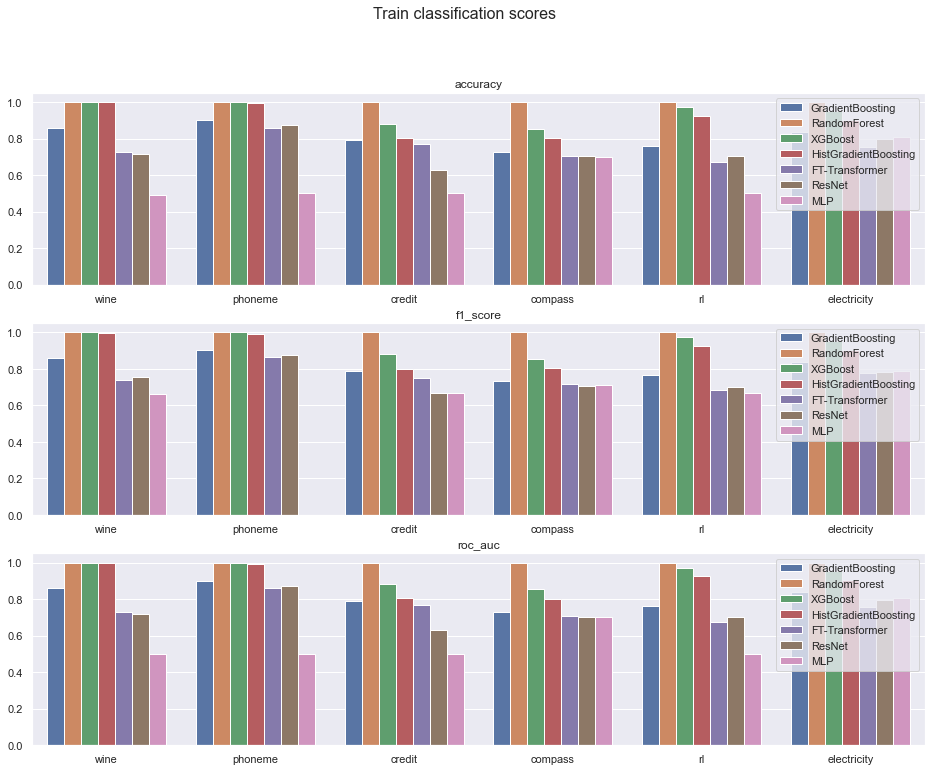

In [ ]:
visualize_bar(train_classif_scores, "Train classification scores")

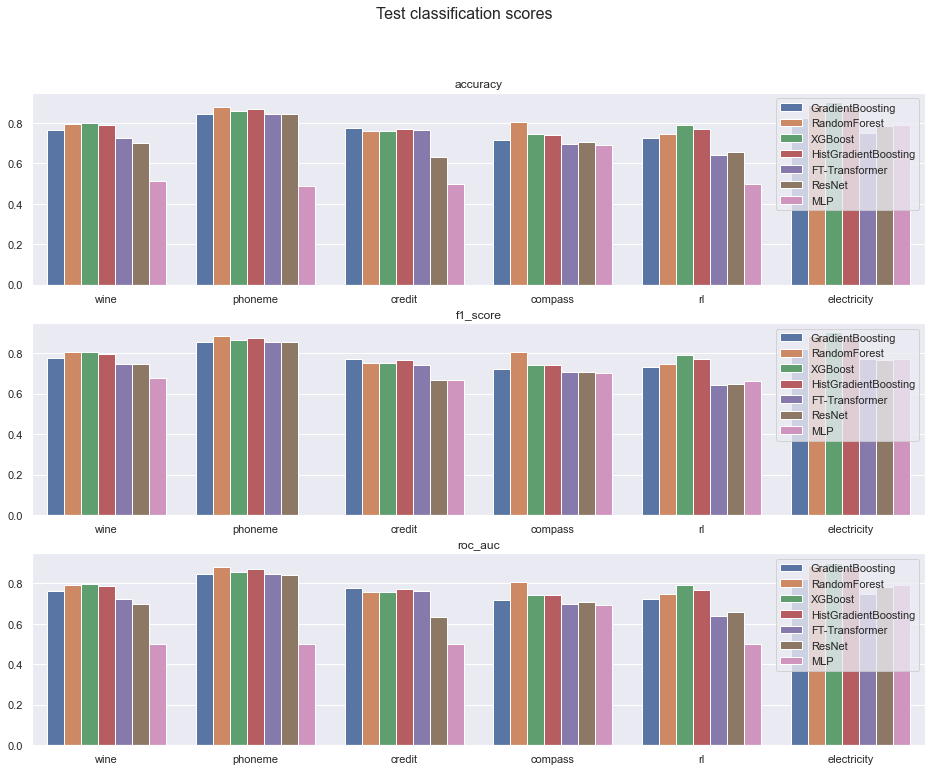

In [ ]:
visualize_bar(test_classif_scores, "Test classification scores")

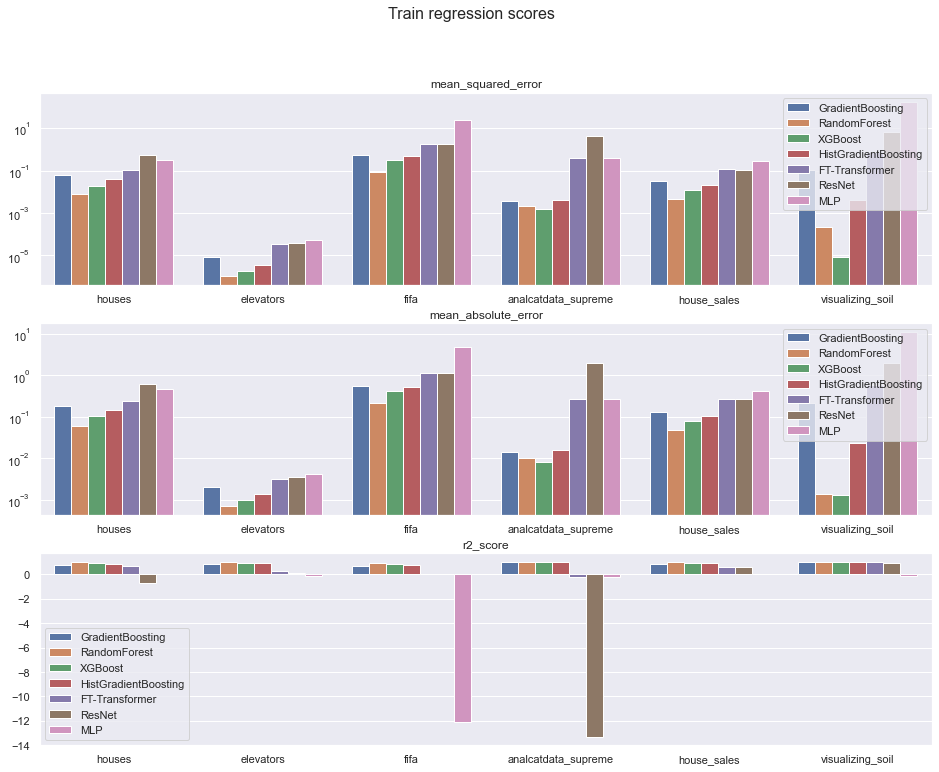

In [ ]:
visualize_bar(train_regression_scores, "Train regression scores")

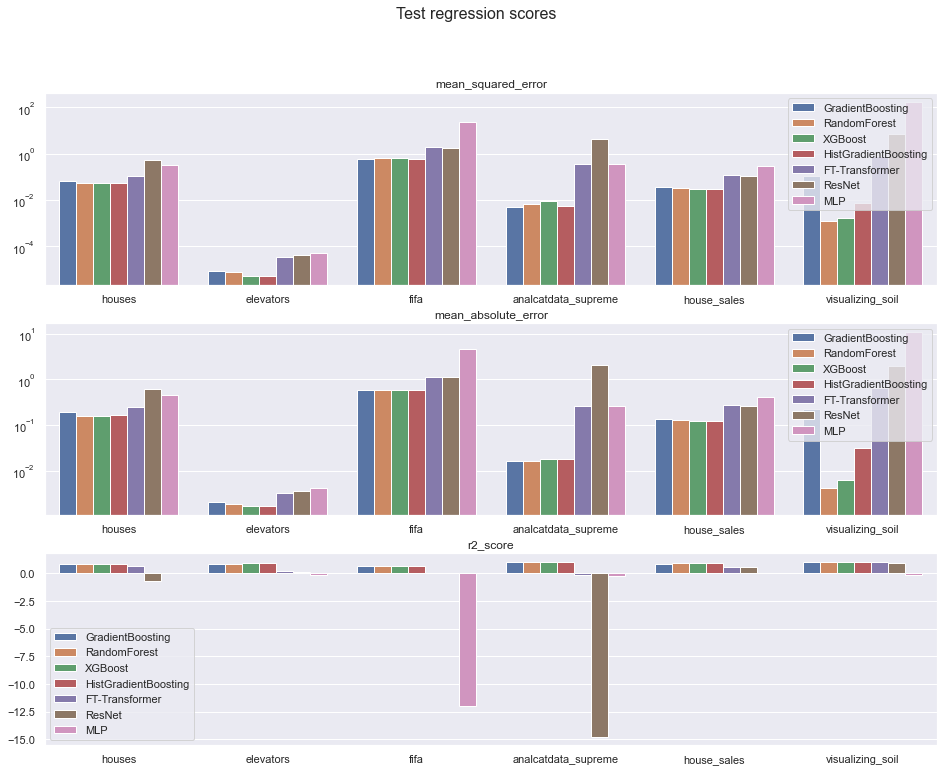

In [ ]:
visualize_bar(test_regression_scores, "Test regression scores")

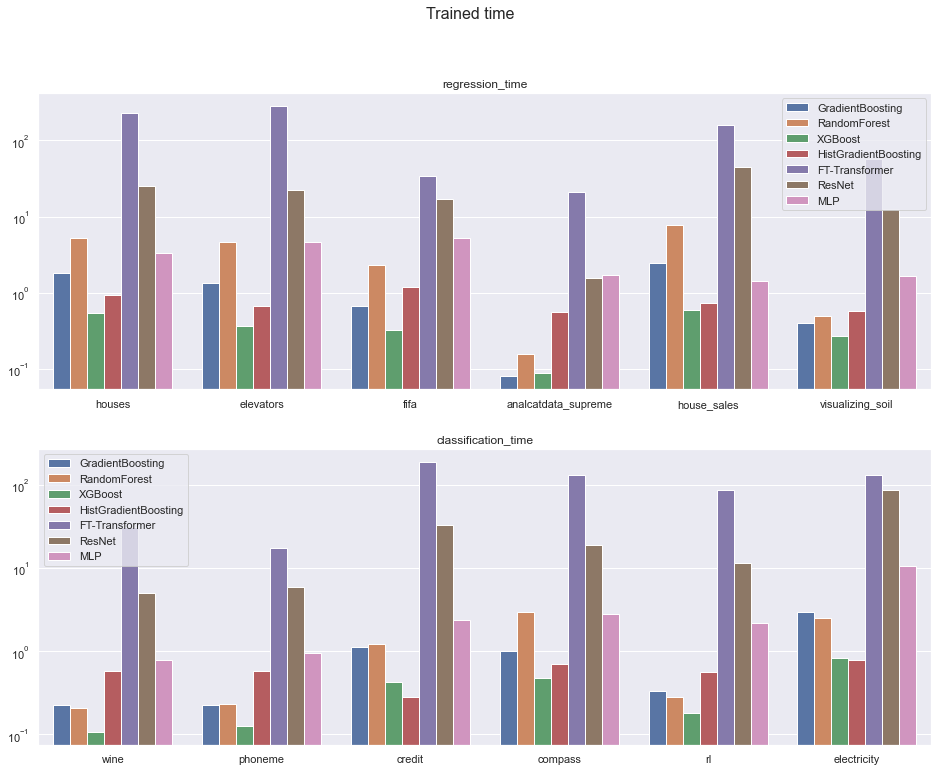

In [ ]:
visualize_bar({"regression_time": time_df.iloc[:,:6], "classification_time": time_df.iloc[:,6:]}, "Trained time")

## Rotation

In [ ]:
rotation_train_regression_scores, rotation_test_regression_scores, rotation_train_classif_scores, rotation_test_classif_scores, rotation_time_df = conduct_experiments(benchmarks, models, random_rotation=True)

Comparing on benchmark houses
	 training gbt
		mean_squared_error: train 0.2287726792503973, test 0.2433084815754039
		mean_absolute_error: train 0.38958583242118944, test 0.40083642305110423
		r2_score: train 0.29246996121679036, test 0.2517475904335532
		time: 2.519273042678833 sec
	 training rf
		mean_squared_error: train 0.033154548895265895, test 0.23870926192162112
		mean_absolute_error: train 0.14436977273668034, test 0.39167879911202175
		r2_score: train 0.8974622348150579, test 0.2658916809551235
		time: 6.551218032836914 sec
	 training xgb
		mean_squared_error: train 0.12190020084381104, test 0.239840567111969
		mean_absolute_error: train 0.27787068486213684, test 0.39193812012672424
		r2_score: train 0.6229966894809571, test 0.262412537057235
		time: 0.7161757946014404 sec
	 training hgbt
		mean_squared_error: train 0.19441998818687894, test 0.2309277922666811
		mean_absolute_error: train 0.35632768718271984, test 0.3893027037206007
		r2_score: train 0.39871324568641764, tes

/Users/sizov/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


		accuracy: train 0.9681029658645776, test 0.727509778357236
		f1_score: train 0.9680672268907563, test 0.7429274292742927
		roc_auc: train 0.9682489570413801, test 0.7263645025180346
		time: 0.663917064666748 sec
	 training ft_transformer
		accuracy: train 0.5881365416899832, test 0.6101694915254238
		f1_score: train 0.6749116607773852, test 0.6964467005076143
		roc_auc: train 0.591670111875321, test 0.6021879678780455
		time: 11.2518630027771 sec
	 training resnet
		accuracy: train 0.7498601007274762, test 0.7209908735332464
		f1_score: train 0.7396622015142691, test 0.7249357326478149
		roc_auc: train 0.7494800866939778, test 0.7212093371444127
		time: 4.5639588832855225 sec
	 training mlp
		accuracy: train 0.6703973139339675, test 0.6571056062581486
		f1_score: train 0.6927490871152844, test 0.6931155192532089
		roc_auc: train 0.671444857869483, test 0.6541751735402205
		time: 0.5357990264892578 sec
Comparing on benchmark phoneme
	 training gbt
		accuracy: train 0.8743243243243243,

/Users/sizov/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


		accuracy: train 0.9882882882882883, test 0.8634453781512605
		f1_score: train 0.9882032667876589, test 0.873046875
		roc_auc: train 0.9883139241821493, test 0.8621580446446314
		time: 0.709022045135498 sec
	 training ft_transformer
		accuracy: train 0.8599099099099099, test 0.8434873949579832
		f1_score: train 0.8638949671772428, test 0.8560386473429952
		roc_auc: train 0.8602845503048347, test 0.8419222362058687
		time: 20.03858184814453 sec
	 training resnet
		accuracy: train 0.8644144144144145, test 0.8466386554621849
		f1_score: train 0.8693009118541033, test 0.8593448940269751
		roc_auc: train 0.8648698557361774, test 0.8450023183413923
		time: 5.073238134384155 sec
	 training mlp
		accuracy: train 0.8657657657657658, test 0.8592436974789915
		f1_score: train 0.8627992633517495, test 0.8646464646464647
		roc_auc: train 0.8656365084145102, test 0.8587798900443796
		time: 0.7138519287109375 sec
Comparing on benchmark credit
	 training gbt
		accuracy: train 0.6203949055474827, test

/Users/sizov/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


		accuracy: train 0.7979314471322335, test 0.5932203389830508
		f1_score: train 0.79016509852654, test 0.5836734693877551
		roc_auc: train 0.797915774556967, test 0.5932437913018584
		time: 0.6455378532409668 sec
	 training hgbt
		accuracy: train 0.6251816394563638, test 0.5938185443668993
		f1_score: train 0.624925156102985, test 0.596393897364771
		roc_auc: train 0.6251814613963893, test 0.5938127728606531
		time: 0.3360917568206787 sec
	 training ft_transformer
		accuracy: train 0.560988118642619, test 0.5752741774675972
		f1_score: train 0.5936708860759494, test 0.6068660022148394
		roc_auc: train 0.5610225976574441, test 0.5751946306590008
		time: 37.636417865753174 sec
	 training resnet
		accuracy: train 0.5821865116676639, test 0.5982053838484547
		f1_score: train 0.4802211824755423, test 0.49937888198757757
		roc_auc: train 0.5821027772332085, test 0.5984027960016223
		time: 19.725552797317505 sec
	 training mlp
		accuracy: train 0.5002136934780751, test 0.4995014955134596
		f1

/Users/sizov/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


		accuracy: train 0.8572532188841202, test 0.6798157789347217
		f1_score: train 0.8582630188357623, test 0.6843040473840079
		roc_auc: train 0.8572458952656743, test 0.6798609774561506
		time: 1.0496041774749756 sec
	 training hgbt
		accuracy: train 0.741030042918455, test 0.6896275530636764
		f1_score: train 0.7445168938944873, test 0.6918489065606362
		roc_auc: train 0.7410147119223676, test 0.6896531814157589
		time: 0.6833088397979736 sec
	 training ft_transformer
		accuracy: train 0.6918454935622318, test 0.6900280336403685
		f1_score: train 0.714171974522293, test 0.7123745819397993
		roc_auc: train 0.6917526245354632, test 0.6902512606335887
		time: 173.73066020011902 sec
	 training resnet
		accuracy: train 0.6854077253218884, test 0.683820584701642
		f1_score: train 0.6499188079090649, test 0.6479375696767001
		roc_auc: train 0.6855305374126275, test 0.6835402312123895
		time: 27.61237096786499 sec
	 training mlp
		accuracy: train 0.5006008583690987, test 0.4985983179815779
		f

/Users/sizov/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


		accuracy: train 0.9896521989077322, test 0.6237424547283702
		f1_score: train 0.9896611143021253, test 0.6311637080867849
		roc_auc: train 0.9896530037470413, test 0.6238169438826552
		time: 0.3011200428009033 sec
	 training hgbt
		accuracy: train 0.8996838171888474, test 0.6270959087860496
		f1_score: train 0.8997990238300315, test 0.6417525773195877
		roc_auc: train 0.8996840230890188, test 0.6272401594921585
		time: 0.6680760383605957 sec
	 training ft_transformer
		accuracy: train 0.608508192009198, test 0.6049631120053656
		f1_score: train 0.648062015503876, test 0.6406345332519829
		roc_auc: train 0.6083479242554334, test 0.6053027903930446
		time: 28.66879892349243 sec
	 training resnet
		accuracy: train 0.6363897671744754, test 0.6405097250167673
		f1_score: train 0.6483180428134557, test 0.6482939632545932
		roc_auc: train 0.6363423350895316, test 0.6405911502004448
		time: 6.448160886764526 sec
	 training mlp
		accuracy: train 0.6312158666283415, test 0.6116700201207244
		f

/Users/sizov/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


		accuracy: train 0.8744940774572054, test 0.772676080741575
		f1_score: train 0.8746197789153498, test 0.7741435703219143
		roc_auc: train 0.8745079681430468, test 0.7726738881441573
		time: 1.2772150039672852 sec
	 training hgbt
		accuracy: train 0.800935724629609, test 0.7578619076496578
		f1_score: train 0.8033742893819916, test 0.7615391178227113
		roc_auc: train 0.8009881041396064, test 0.7577868563305267
		time: 0.9647202491760254 sec
	 training ft_transformer
		accuracy: train 0.754632208235862, test 0.7391492679546046
		f1_score: train 0.7432589944828659, test 0.7269429581935251
		roc_auc: train 0.7544882312756878, test 0.7395574343139271
		time: 433.2215690612793 sec
	 training resnet
		accuracy: train 0.7796219969551818, test 0.7711166941003206
		f1_score: train 0.790674708143759, test 0.7834071159206428
		roc_auc: train 0.7798136344545796, test 0.7707095431885085
		time: 43.58550310134888 sec
	 training mlp
		accuracy: train 0.7370688054658201, test 0.7322186606601403
		f1_

In [ ]:
rotation_model_naming = {'gbt': 'GradientBoosting', 'rf': 'RandomForest', 'xgb': 'XGBoost', 'hgbt': 'HistGradientBoosting', 'ft_transformer': 'FT-Transformer', 'resnet': 'ResNet', 'mlp': 'MLP', 'gbt_rotated': 'GradientBoosting_rotated', 'rf_rotated': 'RandomForest_rotated', 'xgb_rotated': 'XGBoost_rotated', 'hgbt_rotated': 'HistGradientBoosting_rotated', 'ft_transformer_rotated': 'FT-Transformer_rotated', 'resnet_rotated': 'ResNet_rotated', 'mlp_rotated': 'MLP_rotated'}
color_mapping = {'GradientBoosting': (0.2980392156862745, 0.4470588235294118, 0.6901960784313725), 'RandomForest': (0.8666666666666667, 0.5176470588235295, 0.3215686274509804), 'XGBoost': (0.3333333333333333, 0.6588235294117647, 0.40784313725490196), 'HistGradientBoosting': (0.7686274509803922, 0.3058823529411765, 0.3215686274509804), 'FT-Transformer': (0.5058823529411764, 0.4470588235294118, 0.7019607843137254), 'ResNet': (0.5764705882352941, 0.47058823529411764, 0.3764705882352941), 'MLP': (0.8549019607843137, 0.5450980392156862, 0.7647058823529411), 'GradientBoosting_rotated': (0.6313725490196078, 0.788235294117647, 0.9568627450980393), 'RandomForest_rotated': (1.0, 0.7058823529411765, 0.5098039215686274), 'XGBoost_rotated': (0.5529411764705883, 0.8980392156862745, 0.6313725490196078), 'HistGradientBoosting_rotated': (1.0, 0.6235294117647059, 0.6078431372549019), 'FT-Transformer_rotated': (0.8156862745098039, 0.7333333333333333, 1.0), 'ResNet_rotated': (0.8705882352941177, 0.7333333333333333, 0.6078431372549019), 'MLP_rotated': (0.9803921568627451, 0.6901960784313725, 0.8941176470588236)}
def visualize_compare_bar(scores, rot_scores, title):
    fig, axs = plt.subplots(len(scores), 1)
    fig.set_size_inches(20, 16)
    fig.suptitle(title, fontsize=16)
    for i, metric in enumerate(scores):
        df = scores[metric]
        rot_df = rot_scores[metric].copy()
        rot_df.index = rot_df.index + '_rotated'
        df = pd.concat((df, rot_df))
        sns.barplot(ax=axs[i], x=np.repeat(df.columns, df.shape[0]), y=df.values.T.flatten(), hue=np.tile(df.index.map(rotation_model_naming), df.shape[1]), palette=color_mapping)
        if i == len(scores) - 1:
            sns.move_legend(axs[i], "lower right")
        else:
            axs[i].legend_.remove()
        axs[i].set_title(metric, fontsize=12)
        if metric in log_scale_metrics:
            axs[i].set_yscale("log")

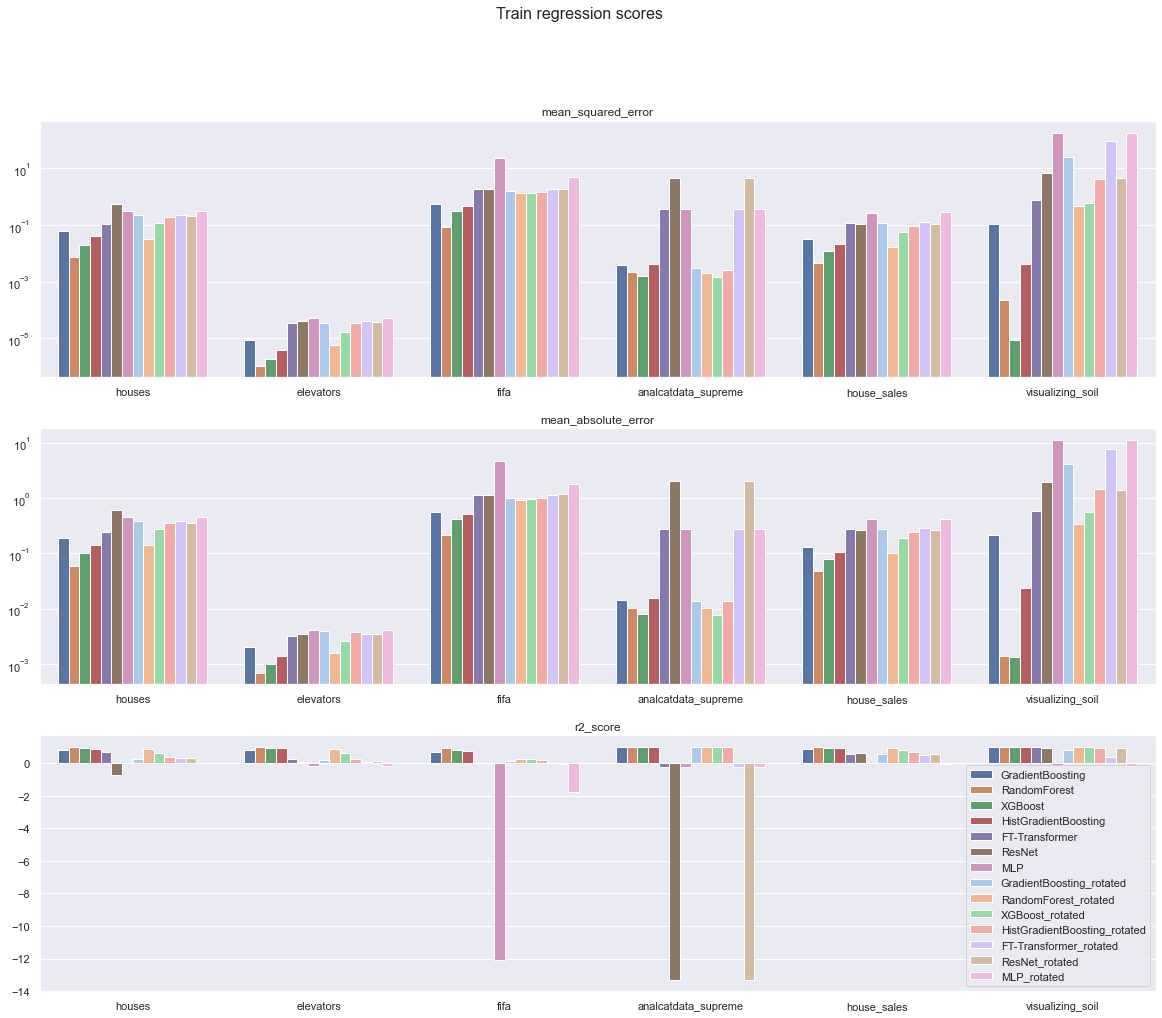

In [ ]:
visualize_compare_bar(train_regression_scores, rotation_train_regression_scores, "Train regression scores")

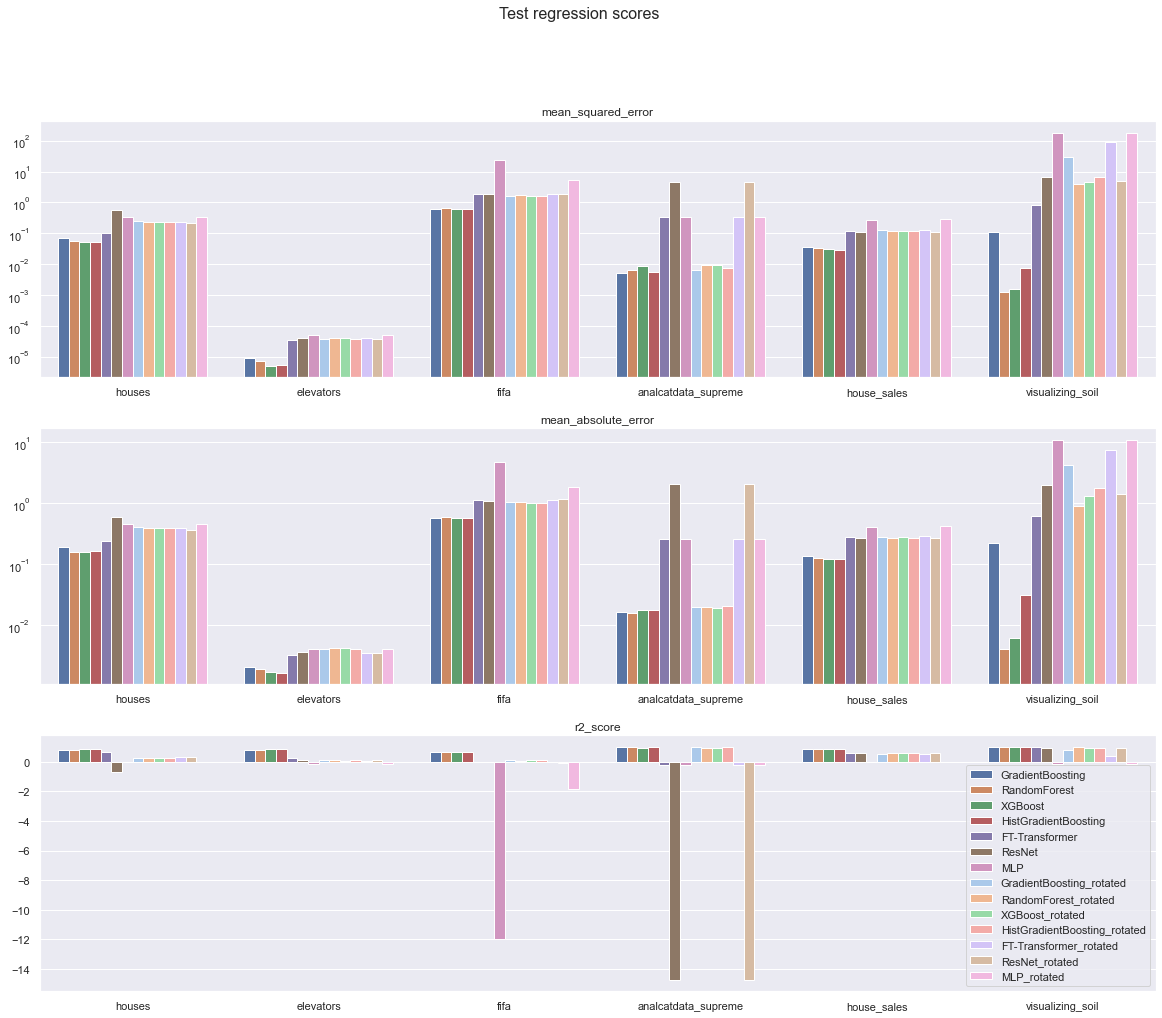

In [ ]:
visualize_compare_bar(test_regression_scores, rotation_test_regression_scores, "Test regression scores")

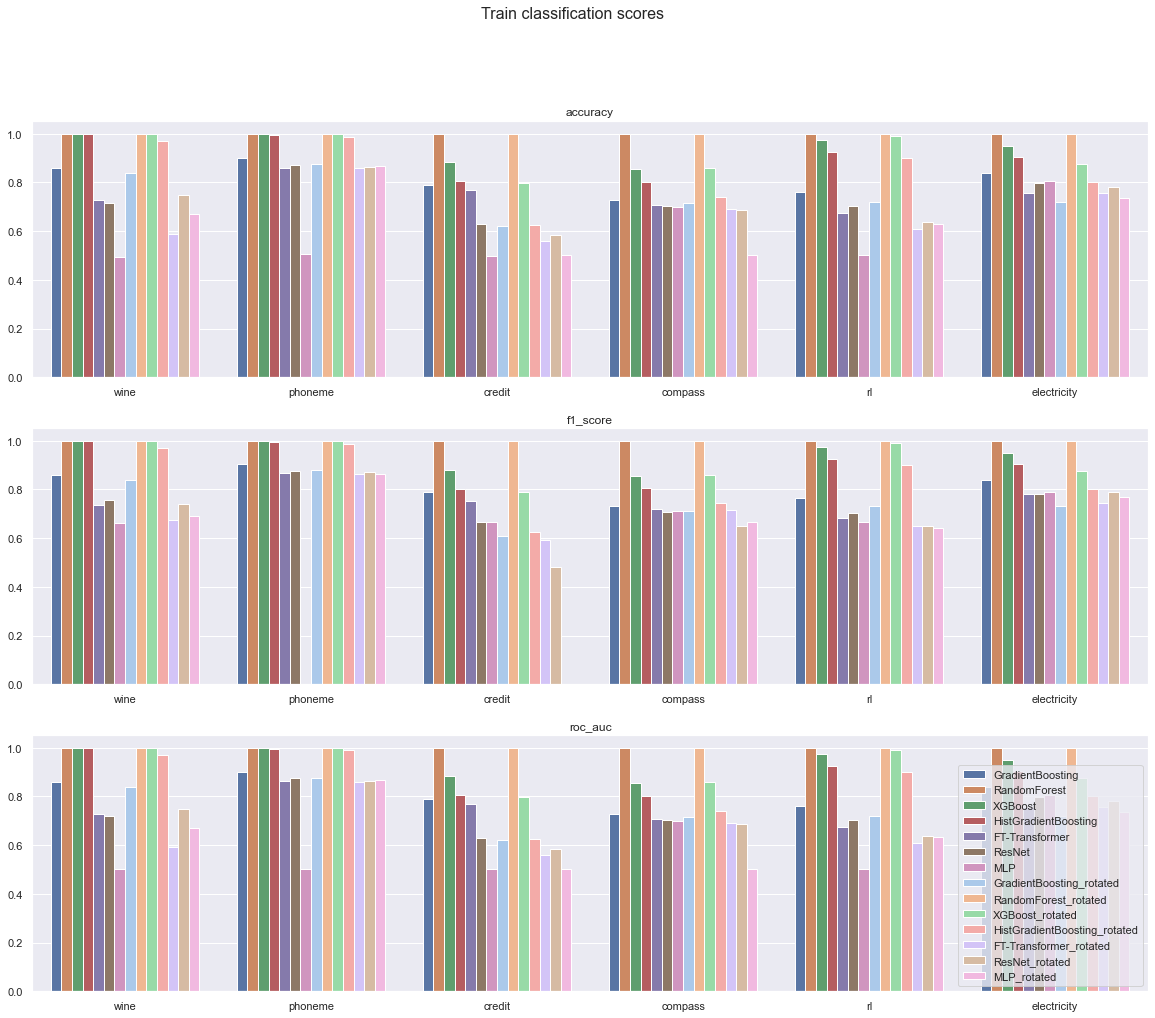

In [ ]:
visualize_compare_bar(train_classif_scores, rotation_train_classif_scores, "Train classification scores")

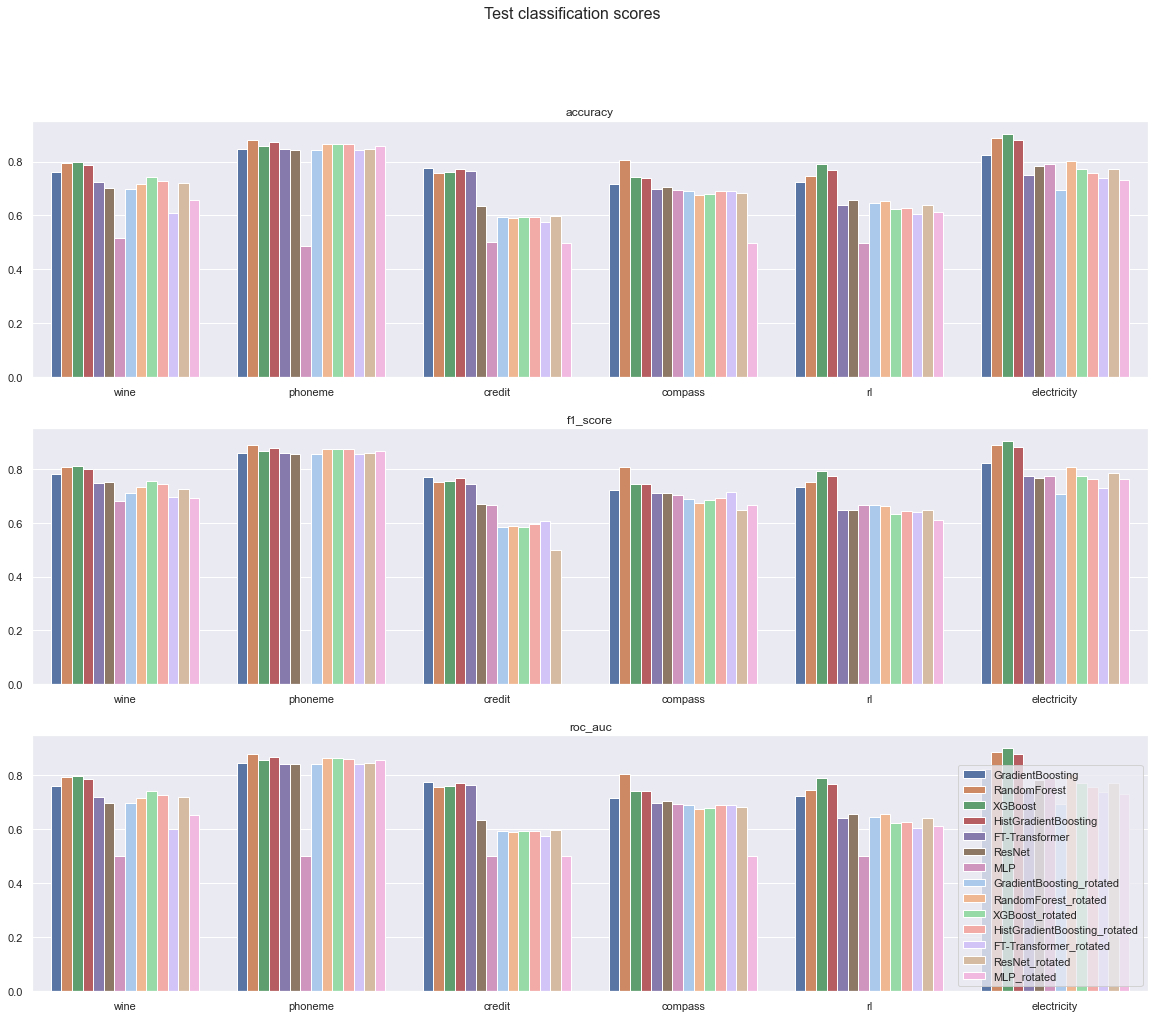

In [ ]:
visualize_compare_bar(test_classif_scores, rotation_test_classif_scores, "Test classification scores")